# Tracking iceberg in Ross Sea in 2017-2020

- Created by YoungHyun Koo (kooala317@gmail.com, younghyun.koo@my.utsa.edu)
- Center for Advanced Measurements in Extreme Environments, University of Texas at San Antonio
- Last updated: 09/26/2020

I found an iceberg floating in Ross Sea. This iceberg started its journey in 2017 from Belingshousen Sea, moved to Ross Sea, and disappeared in April 2020 in the north of Ross Sea. This tool is made for tracking this iceberg by using Sentinel-1 images through Google Earth Engine (GEE) platform.


In [1]:
## Import required packages =======================================
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import geopandas
import h5py

### (1) Visualize Sentinel-1 iceberg images in GEE
Next, you will visualize the Sentinel-1 SAR image in GEE.

You will use Python API for GEE. Make sure that "ee" module is installed.
* Refer to this link: https://developers.google.com/earth-engine/python_install

In [2]:
# Import package for GEE
import ee
import folium
# ee.Authenticate()
ee.Initialize()

## First, you have to initialize the dictionaries
ice_area = {}
ice_centroid = {}
mapid_seg = {}
mapid_target = {}


Now let's load the Sentinel-2 image and ATL03 shapefile by using GEE Python API.

In [ ]:
import datetime as dt

# initial condition
# This is reverese-tracking: current date to past date
startdate = '2019-12-12' # Tracking start date
enddate = '2019-12-13' # Tracking start date
center = [-172.3, -71.9] # initial center
buf_dist = 25000 # buffer distance to find from the center to find icebergs

# color codes to visualize the iceberg geometry by time
color_codes = ['magenta', 'maroon', 'red', 'chocolate', 'orange', 'yellow',
               'olive', 'lime', 'green', 'teal', 'cyan', 'blue', 'navy', 'purple']
color_idx = 0

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist);

# Map initialization (note: if you run this code, map is entirely initialized!)
map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# How many days are you testing?
day_range = range(0, 340) # for about year (2019-2018)

features = []

for day in day_range:
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)
    band = "HH" # intersted band

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', band))   
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(ross_sea) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(50);
        img = imageA
        
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img = img.convolve(kernel)
        
        # SNIC image segmentaion
        # https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 32, 5, 8, 256)\
        .select(["{0}_mean".format(band), "clusters"], [band, "clusters"])
        # ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)

        cluster = snic.select(band)       
        
        value_mean = cluster.reduceRegion(reducer=ee.Reducer.mean(), geometry=cluster.geometry(),
                                          scale = 100, maxPixels=1e9).getInfo()[band]
        value_std = cluster.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=cluster.geometry(), 
                                         scale = 100, maxPixels=1e9).getInfo()[band]
    
        if value_mean == None:
            value_mean = -15
        if value_std == None:
            value_std = 2
        
        # Normalization of the image
        normal = cluster.subtract(value_mean).divide(value_std)
        
        icebergs = normal.gt(2.5).selfMask()

        objectId = icebergs.connectedComponents(ee.Kernel.plus(1), 256)
        # print(objectId)
        
        # Convert iceberg raster to vector
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = 80,
            geometryType = 'polygon',
            labelProperty = 'target',
            maxPixels = 1e12)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = 95000000
        area_min = 75000000
        areaAdded = vectors.map(addArea)
        # Add area and centroid information to the iceberg vectors
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        if target.size().getInfo() > 0: # if there is a valid iceberg
            
            area = target.getInfo()['features'][0]['properties']['area']
            centroid = target.getInfo()['features'][0]['properties']['centroid']['coordinates']

            ice_area[startdate] = area
            ice_centroid[startdate] = centroid

            # Mapping parameters
            vis_seg = {'bands': [band], 'min': -3, 'max': 3, 'region': ross_sea}
            mapid_seg[startdate] = normal.getMapId(vis_seg)

            vis_target = {'color': color_codes[color_idx%len(color_codes)]}
            mapid_target[startdate] = target.getMapId(vis_target)            

            # Map of Sentinel1 segmentation image
            folium.TileLayer(
              tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
              attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
              overlay=True,
              name='S1_{0}'.format(startdate),
            ).add_to(map)

            # Map of iceberg vectors
            folium.TileLayer(
              tiles=mapid_target[startdate]['tile_fetcher'].url_format,
              attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
              overlay=True,
              name=startdate,
            ).add_to(map)
            
            print("{0} area: {1} km^2, centroid: {2}".format(startdate, round(area/1e6,3), centroid))            
            
            task = ee.batch.Export.table.toDrive(
                collection = target,
                folder = 'Iceberg_tracking',
                description = "Iceberg_{0}".format(startdate),
                fileFormat = 'KML'
            )

            task.start()
            print("... exporting task for {0}".format(startdate))
            
            center = centroid
            buf_dist = 0
            color_idx += 1
            
    if buf_dist > 200000: # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 25000 # add 25 km buffer for everyday searching process
    enddate = startdate
    startdate = (dt.datetime.strptime(startdate, "%Y-%m-%d") - dt.timedelta(days=1)).strftime("%Y-%m-%d")

map.add_child(folium.LayerControl())
map

### 2019 (Automatic by August)

In [ ]:
import datetime as dt

# initial condition
# This is reverese-tracking: current date to past date
startdate = '2019-12-12' # Tracking start date
enddate = '2019-12-13' # Tracking start date
center = [-172.3, -71.9] # initial center
buf_dist = 25000 # buffer distance to find from the center to find icebergs

# color codes to visualize the iceberg geometry by time
color_codes = ['magenta', 'maroon', 'red', 'chocolate', 'orange', 'yellow',
               'olive', 'lime', 'green', 'teal', 'cyan', 'blue', 'navy', 'purple']
color_idx = 0

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist);

# Map initialization (note: if you run this code, map is entirely initialized!)
map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# How many days are you testing?
day_range = range(0, 340) # for about year (2019-2018)

features = []

for day in day_range:
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)
    band = "HH" # intersted band

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', band))   
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(ross_sea) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(50);
        img = imageA
        
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img = img.convolve(kernel)
        
        # SNIC image segmentaion
        # https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 32, 5, 8, 256)\
        .select(["{0}_mean".format(band), "clusters"], [band, "clusters"])
        # ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)

        cluster = snic.select(band)       
        
        value_mean = cluster.reduceRegion(reducer=ee.Reducer.mean(), geometry=cluster.geometry(),
                                          scale = 100, maxPixels=1e9).getInfo()[band]
        value_std = cluster.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=cluster.geometry(), 
                                         scale = 100, maxPixels=1e9).getInfo()[band]
    
        if value_mean == None:
            value_mean = -15
        if value_std == None:
            value_std = 2
        
        # Normalization of the image
        normal = cluster.subtract(value_mean).divide(value_std)
        
        icebergs = normal.gt(2.5).selfMask()

        objectId = icebergs.connectedComponents(ee.Kernel.plus(1), 256)
        # print(objectId)
        
        # Convert iceberg raster to vector
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = 80,
            geometryType = 'polygon',
            labelProperty = 'target',
            maxPixels = 1e12)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = 95000000
        area_min = 75000000
        areaAdded = vectors.map(addArea)
        # Add area and centroid information to the iceberg vectors
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        if target.size().getInfo() > 0: # if there is a valid iceberg
            
            area = target.getInfo()['features'][0]['properties']['area']
            centroid = target.getInfo()['features'][0]['properties']['centroid']['coordinates']

            ice_area[startdate] = area
            ice_centroid[startdate] = centroid

            # Mapping parameters
            vis_seg = {'bands': [band], 'min': -3, 'max': 3, 'region': ross_sea}
            mapid_seg[startdate] = normal.getMapId(vis_seg)

            vis_target = {'color': color_codes[color_idx%len(color_codes)]}
            mapid_target[startdate] = target.getMapId(vis_target)            

            # Map of Sentinel1 segmentation image
            folium.TileLayer(
              tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
              attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
              overlay=True,
              name='S1_{0}'.format(startdate),
            ).add_to(map)

            # Map of iceberg vectors
            folium.TileLayer(
              tiles=mapid_target[startdate]['tile_fetcher'].url_format,
              attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
              overlay=True,
              name=startdate,
            ).add_to(map)
            
            print("{0} area: {1} km^2, centroid: {2}".format(startdate, round(area/1e6,3), centroid))            
            
            task = ee.batch.Export.table.toDrive(
                collection = target,
                folder = 'Iceberg_tracking',
                description = "Iceberg_{0}".format(startdate),
                fileFormat = 'KML'
            )

            task.start()
            print("... exporting task for {0}".format(startdate))
            
            center = centroid
            buf_dist = 0
            color_idx += 1
            
    if buf_dist > 200000: # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 25000 # add 25 km buffer for everyday searching process
    enddate = startdate
    startdate = (dt.datetime.strptime(startdate, "%Y-%m-%d") - dt.timedelta(days=1)).strftime("%Y-%m-%d")

map.add_child(folium.LayerControl())
map

### 2019 (Manual)

In [ ]:
# initial condition
# This is reverese-tracking: current date to past date
startdate = '2019-06-27'; enddate = '2019-06-28' # Tracking start date
center = [-160.465,-76.355] # initial center

startdate = '2019-05-22'; enddate = '2019-05-23' # Tracking start date
center = [-154.254,-75.825] # initial center

startdate = '2019-05-10'; enddate = '2019-05-11' # Tracking start date
center = [-151.7055451013548,-75.38849511386131]
 
startdate = '2019-04-15'; enddate = '2019-04-16' # Tracking start date
center = [-147.2890411951048,-74.55108403154487]

startdate = '2019-04-03'; enddate = '2019-04-04' # Tracking start date
center = [-145.44883123416727,-74.74306128117281]

startdate = '2019-03-22'; enddate = '2019-03-23' # Tracking start date
center = [-143.01535955447977,-74.04568251050486]

startdate = '2019-03-17'; enddate = '2019-03-18' # Tracking start date
center = [-140.58738103885477,-74.19597961142911]

startdate = '2019-03-13'; enddate = '2019-03-14' # Tracking start date
center = [-139.64014827323481,-73.93239820313856]

startdate = '2019-02-26'; enddate = '2019-02-27' # Tracking start date
center = [-137.50022283572977,-73.39909755565317]

startdate = '2019-02-14'; enddate = '2019-02-15' # Tracking start date
center = [-136.00608221072977,-73.34250504837408]

startdate = '2019-02-02'; enddate = '2019-02-03' # Tracking start date
center = [-136.26975408572977, -73.37396843475759]

startdate = '2019-01-21'; enddate = '2019-01-22' # Tracking start date
center = [-136.00608221072977,-73.45863136532253]

startdate = '2019-01-09'; enddate = '2019-01-10'
center = [-135.00632635135477,-73.49924539610532]

buf_dist = 25000 # buffer distance to find from the center to find icebergs

map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# color codes to visualize the iceberg geometry by time
color_codes = ['magenta', 'maroon', 'red', 'chocolate', 'orange', 'yellow',
               'olive', 'lime', 'green', 'teal', 'cyan', 'blue', 'navy', 'purple']
color_idx = 0

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist);

# How many days are you testing?
day_range = range(0, 1) # for about year (2019-2018)

features = []

for day in day_range:
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)
    band = "HH" # intersted band

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', band))   
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(ross_sea) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(50);
        
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        
        img = img1.select("HH")
        
        # SNIC image segmentaion
        # https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 32, 5, 8, 256)\
        .select(["{0}_mean".format(band), "clusters"], [band, "clusters"])
        # ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)

        cluster = snic.select(band)       
        
        value_mean = cluster.reduceRegion(reducer=ee.Reducer.mean(), geometry=cluster.geometry(),
                                          scale = 100, maxPixels=1e9).getInfo()[band]
        value_std = cluster.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=cluster.geometry(), 
                                         scale = 100, maxPixels=1e9).getInfo()[band]
    
        if value_mean == None:
            value_mean = -15
        if value_std == None:
            value_std = 2
        
        # Normalization of the image
        normal = cluster.subtract(value_mean).divide(value_std)
        
        icebergs = normal.gt(1.5).selfMask()

        objectId = icebergs.connectedComponents(ee.Kernel.plus(1), 256)
        # print(objectId)
        
        # Convert iceberg raster to vector
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = 80,
            geometryType = 'polygon',
            labelProperty = 'target',
            maxPixels = 1e12)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = 100000000
        area_min = 75000000
        areaAdded = vectors.map(addArea)
        # Add area and centroid information to the iceberg vectors
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        # Mapping parameters
        vis_seg = {'bands': [band], 'min': -3, 'max': 3, 'region': ross_sea}
        mapid_seg[startdate] = normal.getMapId(vis_seg)

        # Map of Sentinel1 segmentation image
        folium.TileLayer(
          tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='S1_{0}'.format(startdate),
        ).add_to(map)
        
        if target.size().getInfo() > 0: # if there is a valid iceberg
            
            area = target.getInfo()['features'][0]['properties']['area']
            centroid = target.getInfo()['features'][0]['properties']['centroid']['coordinates']

            ice_area[startdate] = area
            ice_centroid[startdate] = centroid
            
            vis_target = {'color': color_codes[color_idx%len(color_codes)]}
            mapid_target[startdate] = target.getMapId(vis_target)  

            # Map of iceberg vectors
            folium.TileLayer(
              tiles=mapid_target[startdate]['tile_fetcher'].url_format,
              attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
              overlay=True,
              name=startdate,
            ).add_to(map)
            
            print("{0} area: {1} km^2, centroid: {2}".format(startdate, round(area/1e6,3), centroid))            
            
            task = ee.batch.Export.table.toDrive(
                collection = target,
                folder = 'Iceberg_tracking',
                description = "Iceberg_{0}".format(startdate),
                fileFormat = 'KML'
            )

#             task.start()
            print("... exporting task for {0}".format(startdate))
            
            center = centroid
            buf_dist = 0
            color_idx += 1
            
    if buf_dist > 250000: # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 25000 # add 25 km buffer for everyday searching process
    enddate = startdate
    startdate = (dt.datetime.strptime(startdate, "%Y-%m-%d") - dt.timedelta(days=1)).strftime("%Y-%m-%d")

map.add_child(folium.LayerControl())
map

### 2018

In [ ]:
# This is reverese-tracking: current date to past date
startdate = '2018-11-18'; enddate = '2018-11-19' # Tracking start date
center = [-127.85971990604227,-72.99658459334805] # initial center

startdate = '2018-11-03'; enddate = '2018-11-04' # Tracking start date
center = [-127.77732244510477,-72.5360410393514]

startdate = '2018-10-01'; enddate = '2018-10-02' # Tracking start date
center = [-124.55008855838602,-72.12338058010539]

startdate = '2018-09-02'; enddate = '2018-09-03'
center = [-120.46317449588602,-72.21756841388311]

startdate = '2018-08-09'; enddate = '2018-08-10'
center = [-116.88163152713602,-72.69769188670601]

startdate = '2018-07-04'; enddate = '2018-07-05'
center = [-115.47538152713602,-72.71402181398035]

startdate = '2018-06-08'; enddate = '2018-06-09'
center = [-112.98148504276102,-72.17473900229975]

startdate = '2018-05-15'; enddate = '2018-05-16'
center = [-112.00370183963602,-72.36544039585844]

buf_dist = 25000 # buffer distance to find from the center to find icebergs

map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# color codes to visualize the iceberg geometry by time
color_codes = ['magenta', 'maroon', 'red', 'chocolate', 'orange', 'yellow',
               'olive', 'lime', 'green', 'teal', 'cyan', 'blue', 'navy', 'purple']
color_idx = 0

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist);

# How many days are you testing?
day_range = range(0, 1) # for about year (2019-2018)

features = []

for day in day_range:
    
    band = ["HH", "angle"]  # intersted band
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))   
    
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(ross_sea) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(50);
        
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH', 'angle'], ['HH', 'angle'])
        
        # Mapping original image ===================================
        vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0, 'region': ross_sea}
        mapid_seg[startdate] = img.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='S1_{0}'.format(startdate),
        ).add_to(map)
        
        # SNIC image segmentaion
        # https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 20, 5, 8, 256, seeds)\
        .select(["HH_mean", "angle_mean", "clusters"], ["HH", "angle", "clusters"])
        # ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)
        
        segments = snic.select("clusters").reduceToVectors(
            geometry = snic.geometry(),
            scale = 40,
            geometryType = 'polygon',            
            maxPixels = 1e20
        )     
        
        segimageA = segments.reduceToImage(
            properties = ['label'],
            reducer = ee.Reducer.first()
        ).rename('id')

        segimageB = img.addBands(segimageA)
        
        ratio = segimageB.select("HH").divide(segimageB.select("angle"))
        segimage = segimageB.addBands(ratio)
        segimage = segimage.select(["HH", "id", "HH_1"], ["HH", "id", "ratio"])

        segimage_mean = segimage.reduceConnectedComponents(
            reducer = ee.Reducer.mean(),
            labelBand = 'id',
            maxSize = 512
        ).select('ratio')      
        
        # Mapping segmented image ===================================
        vis_seg = {'bands': ["ratio"], 'min': -0.5, 'max': -0.2, 'region': ross_sea}
        mapid_segimg = segimage_mean.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_segimg['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='Segimage_{0}'.format(startdate),
        ).add_to(map)

        # Map of segmentations =====================================
        vis_seg = {'color': 'red'}
        seg_tile = segments.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=seg_tile['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name="seg_" + startdate,
        ).add_to(map)

#         icebergs = segimage_mean.select('ratio').gt(-0.2).selfMask()
        ratio = snic.select("HH").divide(snic.select("angle"))
        icebergs = ratio.gt(-0.2).selfMask()
        
        # Convert iceberg raster to vector
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = 40,
            geometryType = 'polygon',            
            maxPixels = 1e20)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = 105000000
        area_min = 50000000
        areaAdded = vectors.map(addArea)
        # Add area and centroid information to the iceberg vectors
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        num = target.size().getInfo()
        if num > 0: # if there is a valid iceberg
            
            area = target.getInfo()['features'][0]['properties']['area']
            centroid = target.getInfo()['features'][0]['properties']['centroid']['coordinates']

            ice_area[startdate] = area
            ice_centroid[startdate] = centroid
            
            vis_target = {'color': color_codes[color_idx%len(color_codes)]}
            mapid_target = target.getMapId(vis_target)  

            # Map of iceberg vectors
            folium.TileLayer(
                tiles=mapid_target['tile_fetcher'].url_format,
                attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
                overlay=True,
                name=startdate,
            ).add_to(map)
            
            print("{0} area: {1} km^2, centroid: {2}".format(startdate, round(area/1e6,3), centroid))            
            
            task = ee.batch.Export.table.toDrive(
                collection = target,
                folder = 'Iceberg_tracking',
                description = "Iceberg_{0}".format(startdate),
                fileFormat = 'KML'
            )

            # task.start()
            print("... exporting task for {0}".format(startdate))
            
            sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);
            cover = img_sizes.select('HH').gt(-50).multiply(0).add(1)

            
            center = centroid
            buf_dist = 0
            color_idx += 1
            
    if buf_dist > 250000: # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 25000 # add 25 km buffer for everyday searching process
    enddate = startdate
    startdate = (dt.datetime.strptime(startdate, "%Y-%m-%d") - dt.timedelta(days=1)).strftime("%Y-%m-%d")

map.add_child(folium.LayerControl())
map

## Real segmentation tracking

### Reference iceberg statistics

In [ ]:
# Reference iceberg distribution
reference = ee.FeatureCollection('users/kooala317/iceberg_20180515')
centroid = reference.geometry().centroid(10).getInfo()['coordinates']

band = ["HH", "angle"]  # intersted band
    
# Load Sentinel-1 images (image collection)
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate('2018-05-15', '2018-05-16')\
.filterBounds(reference)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

img = S1A.select(band).mean().clip(reference) # clip image into ROI

scale = 200
max_pix = 20000

cover = img.select('HH').clip(reference).multiply(0).add(1)
cover = cover.addBands(ee.Image.pixelLonLat())
# coordinates = cover.reduceRegion(ee.Reducer.mean(), reference, scale = 200, maxPixels = 1e20).getInfo()
coordinates = reference.geometry().centroid(10).getInfo()['coordinates']

sources = ee.Image().toByte().paint(ee.Geometry.Point(coordinates), 1);

# kernel = ee.Kernel.euclidean(max_pix, "pixels");
# cumulativeCost = sources.distance(kernel, False).clip(reference)
# sources = sources.updateMask(cover);

# Compute the cumulative cost to traverse the land cover.
cumulativeCost = cover.select('HH').cumulativeCost(
    source = sources,
    maxDistance = 30000,
    geodeticDistance = True
).clip(reference)

result = cumulativeCost.reduceRegion(ee.Reducer.toList(), reference, scale = 200, maxPixels = 1e20);
A = result.getInfo()['cumulative_cost'] # 'cumulative_cost' 'constant'
hist0 = np.histogram(A, int(max_pix/scale), [0, max_pix])
area0 = reference.geometry().area(10)
# hist1.append(B)
plt.plot(hist0[1][:-1], hist0[0])

reference.getInfo()['features'][0]
reference.geometry().centroid(10).getInfo()

In [ ]:
plt.plot(hist1[0][1][:-1], hist1[0][0], label = "actual")
plt.plot(hist0[1][:-1], hist0[0], label = "reference")
diff = abs(hist0[0] - B[0])
similarity = 1-np.sum(diff)/np.sum(hist0[0])
plt.legend()
print(similarity)

In [ ]:
startdate = '2018-05-05'; enddate = '2018-05-06'
center = [-112.76175848026102,-72.19826553059568]

buf_dist = 25000 # buffer distance to find from the center to find icebergs

map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# color codes to visualize the iceberg geometry by time
color_codes = ['red', 'chocolate', 'orange', 'yellow', 'olive', 'lime',
               'green', 'teal', 'cyan', 'blue', 'navy', 'purple']

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist);

# How many days are you testing?
day_range = range(0, 30) # for about year (2019-2018)

vectorscale = 40

features = []
hist1 = {}
fig = plt.subplots(figsize = (10, 6))
plt.plot(hist0[1][:-1], hist0[0], label = "reference", color = "k", linestyle = "--")

for day in day_range:
    
    month = dt.datetime.strptime(startdate, "%Y-%m-%d").month
    band = ["HH", "angle"]  # intersted band
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(ross_sea) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(80);
        
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH', 'angle'], ['HH', 'angle'])
        
        # Mapping original image ===================================
        vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0, 'region': ross_sea}
        mapid_seg[startdate] = img.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='S1_{0}'.format(startdate),
        ).add_to(map)
        
        # SNIC image segmentaion
        # https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 20, 5, 8, 256, seeds)\
        .select(["HH_mean", "angle_mean", "clusters"], ["HH", "angle", "clusters"])
        # ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)
        
        segments = snic.select("clusters").reduceToVectors(
            geometry = snic.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20
        )     
        
        segimageA = segments.reduceToImage(
            properties = ['label'],
            reducer = ee.Reducer.first()
        ).rename('id')

#         segimageB = img.addBands(segimageA)
        
#         ratio = segimageB.select("HH").divide(segimageB.select("angle"))
#         segimage = segimageB.addBands(ratio)
#         segimage = segimage.select(["HH", "id", "HH_1"], ["HH", "id", "ratio"])

#         segimage_mean = segimage.reduceConnectedComponents(
#             reducer = ee.Reducer.mean(),
#             labelBand = 'id',
#             maxSize = 512
#         ).select('ratio')      
        

#         icebergs = segimage_mean.select('ratio').gt(-0.2).selfMask()
        ratio = snic.select("HH").divide(snic.select("angle"))
        icebergs = ratio.gt(-0.2).selfMask()
        
        # Mapping segmented image ===================================
        vis_seg = {'bands': ["HH"], 'min': -0.5, 'max': -0.2, 'region': ross_sea}
        mapid_segimg = ratio.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_segimg['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='Segimage_{0}'.format(startdate),
        ).add_to(map)        
        
        # Map of segmentations =====================================
        vis_seg = {'color': 'red'}
        seg_tile = segments.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=seg_tile['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name="seg_" + startdate,
        ).add_to(map)
        
        # Convert iceberg raster to vector
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = 105000000
        area_min = 85000000
        areaAdded = vectors.map(addArea)
        # Add area and centroid information to the iceberg vectors
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        num = target.size().getInfo()
        features = target.getInfo()['features']
        
        print(startdate + " =====================================")
        threshold = 0.8
        
        for k in range(0, num): # if there is a valid iceberg
            
            area = features[k]['properties']['area']
            centroid = features[k]['properties']['centroid']['coordinates']
            polygon = ee.Geometry.Polygon(features[k]['geometry']['coordinates'][0])
            sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);
            covers = snic.select('HH').multiply(0).add(1)
            
            cumCost = covers.cumulativeCost(
                source = sources,
                maxDistance = 30000,
                geodeticDistance = True
            ).clip(polygon)

            result = cumCost.reduceRegion(ee.Reducer.toList(), polygon, scale = 200)
            cumdist = result.getInfo()['cumulative_cost']
            B = np.histogram(cumdist, int(max_pix/scale), [0, max_pix])  
            
            diff = abs(hist0[0] - B[0])
            similarity = 1-np.sum(diff)/np.sum(hist0[0])
            
            plt.plot(B[1][:-1], B[0], label = startdate + "_" + str(k))
            
            vis_target = {'color': color_codes[month-1]}
            mapid_target = ee.FeatureCollection(polygon).getMapId(vis_target) 
            
            # Map of iceberg vectors
            folium.TileLayer(
                tiles=mapid_target['tile_fetcher'].url_format,
                attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
                overlay=True,
                name=startdate + "_" + str(k),
            ).add_to(map)           
            
            print("Feature {0} >>> area: {1} km^2, centroid: [{2}, {3}], similarity: {4}".format(
                k, round(area/1e6,2), round(centroid[0],3), round(centroid[1], 3), round(similarity, 3)
            ))                       
            
            if similarity >= threshold:
                
                ice_area[startdate] = area
                ice_centroid[startdate] = centroid
                hist1[startdate] = B                 
                
                task = ee.batch.Export.table.toDrive(
                    collection = target,
                    folder = 'Iceberg_tracking',
                    description = "Iceberg_{0}".format(startdate),
                    fileFormat = 'KML'
                )
                
                task.start()
                
                print("... exporting task for {0}".format(startdate))
                
                center = centroid
                buf_dist = 0
            
    if buf_dist > 250000: # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 25000 # add 25 km buffer for everyday searching process
    enddate = startdate
    startdate = (dt.datetime.strptime(startdate, "%Y-%m-%d") - dt.timedelta(days=1)).strftime("%Y-%m-%d")

plt.legend()
map.add_child(folium.LayerControl())
map

## Phase 1 (2017/05/01 - 2018/03/18)

{'type': 'Point', 'coordinates': [-107.42839345410263, -74.4979257462871]}

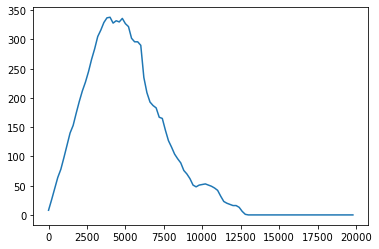

In [5]:
# Reference iceberg distribution
reference = ee.FeatureCollection('users/kooala317/iceberg_20170501')
centroid = reference.geometry().centroid(10).getInfo()['coordinates']

band = ["HH", "angle"]  # intersted band
    
# Load Sentinel-1 images (image collection)
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate('2017-05-01', '2017-05-02')\
.filterBounds(reference)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

img = S1A.select(band).mean().clip(reference) # clip image into ROI

scale = 200
max_pix = 20000

cover = img.select('HH').clip(reference).multiply(0).add(1)
cover = cover.addBands(ee.Image.pixelLonLat())
# coordinates = cover.reduceRegion(ee.Reducer.mean(), reference, scale = 200, maxPixels = 1e20).getInfo()

sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);

# kernel = ee.Kernel.euclidean(max_pix, "pixels");
# cumulativeCost = sources.distance(kernel, False).clip(reference)
# sources = sources.updateMask(cover);

# Compute the cumulative cost to traverse the land cover.
cumulativeCost = cover.select('HH').cumulativeCost(
    source = sources,
    maxDistance = 30000,
    geodeticDistance = True
).clip(reference)

hist1 = {}

result = cumulativeCost.reduceRegion(ee.Reducer.toList(), reference, scale = 200, maxPixels = 1e20);
A = result.getInfo()['cumulative_cost'] # 'cumulative_cost' 'constant'
hist1['reference'] = np.histogram(A, int(max_pix/scale), [0, max_pix])
area0 = reference.geometry().area(10).getInfo()
plt.plot(hist1['reference'][1][:-1], hist1['reference'][0])

reference.getInfo()['features'][0]
reference.geometry().centroid(10).getInfo()

2017-07-22 ============================================
Feature 0 >>> area: 119.7 km^2, centroid: [-107.312, -74.239], similarity: 0.83
... exporting task for 2017-07-22
2017-07-23 ============================================
Feature 0 >>> area: 89.69 km^2, centroid: [-106.849, -74.36], similarity: 0.849
... exporting task for 2017-07-23
Feature 1 >>> area: 117.55 km^2, centroid: [-107.3, -74.234], similarity: 0.862
... exporting task for 2017-07-23
2017-07-24 ============================================
2017-07-25 ============================================
2017-07-26 ============================================
Feature 0 >>> area: 111.3 km^2, centroid: [-107.224, -74.207], similarity: 0.866
... exporting task for 2017-07-26
2017-07-27 ============================================
2017-07-28 ============================================
2017-07-29 ============================================
Feature 0 >>> area: 113.23 km^2, centroid: [-107.236, -74.195], similarity: 0.839
... exporting

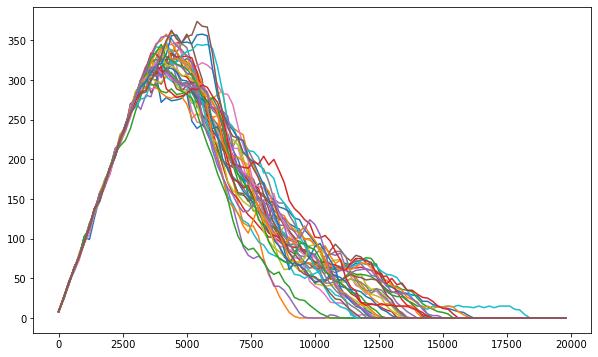

In [22]:
startdate = '2017-05-01'; enddate = '2017-05-02'
center = [-107.41690984744852,-74.5005208661277]

startdate = '2017-09-02'; enddate = '2017-09-03'
center = [-107.27958074588602,-74.07208464463132]

startdate = '2018-01-02'; enddate = '2018-01-03'
center = [-108.32328191776102,-73.52029519701541]

startdate = '2017-04-09'; enddate = '2017-04-10'
center = [-107.07084051151102,-74.68078035824021]

# startdate = '2017-04-16'; enddate = '2017-04-17'
# center = [-107.40592351932352,-74.51885947623116]

# startdate = '2017-04-27'; enddate = '2017-04-28'
# center = [-107.40592351932352,-74.51885947623116]

startdate = '2017-06-18'; enddate = '2017-06-19'
center = [-107.26996770877665,-74.47995646451864]

startdate = '2017-07-22'; enddate = '2017-07-23'
center = [-107.33176580447977,-74.23259146811617]


buf_dist = 25000 # buffer distance to find from the center to find icebergs

map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# color codes to visualize the iceberg geometry by time
color_codes = ['red', 'chocolate', 'orange', 'yellow', 'olive', 'lime',
               'green', 'teal', 'cyan', 'blue', 'navy', 'purple']

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist);

# How many days are you testing?
day_range = range(0, 200) # for about year (2019-2018)

vectorscale = 40

fig = plt.subplots(figsize = (10, 6))
# plt.plot(hist0[1][:-1], hist0[0], label = "reference", color = "k", linestyle = "--")

for day in day_range:
    
    month = dt.datetime.strptime(startdate, "%Y-%m-%d").month
    band = ["HH", "angle"]  # intersted band
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(ross_sea) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(80);
        
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH', 'angle'], ['HH', 'angle'])
        
        # Mapping original image ===================================
        vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0, 'region': ross_sea}
        mapid_seg[startdate] = img.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='S1_{0}'.format(startdate),
        ).add_to(map)
        
        # SNIC image segmentaion
        # https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 20, 5, 8, 256, seeds)\
        .select(["HH_mean", "angle_mean", "clusters"], ["HH", "angle", "clusters"])
        # ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)
        
        segments = snic.select("clusters").reduceToVectors(
            geometry = snic.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20
        )     
        
        segimageA = segments.reduceToImage(
            properties = ['label'],
            reducer = ee.Reducer.first()
        ).rename('id')

#         segimageB = img.addBands(segimageA)
        
#         ratio = segimageB.select("HH").divide(segimageB.select("angle"))
#         segimage = segimageB.addBands(ratio)
#         segimage = segimage.select(["HH", "id", "HH_1"], ["HH", "id", "ratio"])

#         segimage_mean = segimage.reduceConnectedComponents(
#             reducer = ee.Reducer.mean(),
#             labelBand = 'id',
#             maxSize = 512
#         ).select('ratio')      
        

#         icebergs = segimage_mean.select('ratio').gt(-0.2).selfMask()
        ratio = snic.select("HH").divide(snic.select("angle"))
        icebergs = ratio.gt(-0.2).selfMask()
        
        # Mapping segmented image ===================================
        vis_seg = {'bands': ["HH"], 'min': -0.5, 'max': -0.2, 'region': ross_sea}
        mapid_segimg = ratio.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_segimg['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='Segimage_{0}'.format(startdate),
        ).add_to(map)        
        
        # Map of segmentations =====================================
        vis_seg = {'color': 'red'}
        seg_tile = segments.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=seg_tile['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name="seg_" + startdate,
        ).add_to(map)
        
        # Convert iceberg raster to vector
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = area0 * 1.2
        area_min = area0 * 0.8
        areaAdded = vectors.map(addArea)
        # Add area and centroid information to the iceberg vectors
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        num = target.size().getInfo()
        features = target.getInfo()['features']
        
        print(startdate + " ============================================")
        threshold = 0.70
        
        for k in range(0, num): # if there is a valid iceberg
            
            area = features[k]['properties']['area']
            centroid = features[k]['properties']['centroid']['coordinates']
            polygon = ee.FeatureCollection(ee.Geometry.Polygon(features[k]['geometry']['coordinates'][0]))
            sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);
            covers = snic.select('HH').multiply(0).add(1)
            
            cumCost = covers.cumulativeCost(
                source = sources,
                maxDistance = 30000,
                geodeticDistance = True
            ).clip(polygon)

            result = cumCost.reduceRegion(ee.Reducer.toList(), polygon, scale = 200)
            cumdist = result.getInfo()['cumulative_cost']
            B = np.histogram(cumdist, int(max_pix/scale), [0, max_pix])  
            
            diff = abs(hist1['reference'][0] - B[0])
            similarity = 1-np.sum(diff)/np.sum(hist1['reference'][0])
            
            vis_target = {'color': color_codes[month-1]}
            mapid_target = polygon.getMapId(vis_target) 
            
            # Map of iceberg vectors
            folium.TileLayer(
                tiles=mapid_target['tile_fetcher'].url_format,
                attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
                overlay=True,
                name=startdate + "_" + str(k),
            ).add_to(map)           
            
            print("Feature {0} >>> area: {1} km^2, centroid: [{2}, {3}], similarity: {4}".format(
                k, round(area/1e6,2), round(centroid[0],3), round(centroid[1], 3), round(similarity, 3)
            ))                       
            
            if similarity >= threshold:
                
                ice_area[startdate] = area
                ice_centroid[startdate] = centroid
                hist1[startdate] = B 
                plt.plot(B[1][:-1], B[0], label = startdate + "_" + str(k))
                  
                threshold = similarity
                
                def add_columns(feature):
                    return feature.set({"area": feature.geometry().area(10),
                                        "centroid": feature.geometry().centroid(10),
                                        "similarity": similarity,
                                        "refdate": '2017-05-01'});
                
                polygon2 = polygon.map(add_columns)
                
                task = ee.batch.Export.table.toDrive(
                    collection = polygon2,
                    folder = 'Iceberg_tracking_auto',
                    description = "Iceberg_{0}".format(startdate),
                    fileFormat = 'KML'
                )
                
                task.start()
                
                print("... exporting task for {0}".format(startdate))
                
                center = centroid
                buf_dist = 0
            
            
    if (buf_dist > 250000) or (startdate == "2017-09-01"): # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 25000 # add 25 km buffer for everyday searching process
    startdate = enddate
    enddate = (dt.datetime.strptime(enddate, "%Y-%m-%d") + dt.timedelta(days=1)).strftime("%Y-%m-%d")

# plt.legend()


In [676]:
hist2['reference'][0]

array([  8,  24,  41,  52,  76,  94, 113, 118, 143, 165, 174, 188, 213,
       233, 240, 254, 273, 268, 257, 251, 252, 251, 250, 238, 234, 233,
       224, 221, 207, 202, 193, 188, 183, 174, 154, 144, 140, 144, 135,
       133, 126, 119, 110,  99,  89,  83,  68,  50,  39,  33,  23,  12,
         1,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int64)

## Phase 2 (2018/03/18 - 2019/02/28)

94898081.79755262


{'type': 'Point', 'coordinates': [-123.69285615522475, -71.9180658225514]}

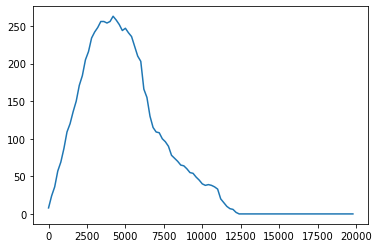

In [702]:
# Reference iceberg distribution
reference = ee.FeatureCollection('users/kooala317/iceberg_20180914')
centroid = reference.geometry().centroid(10).getInfo()['coordinates']

band = ["HH", "angle"]  # intersted band
    
# Load Sentinel-1 images (image collection)
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate('2018-09-14', '2018-09-15')\
.filterBounds(reference)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

img = S1A.select(band).mean().clip(reference) # clip image into ROI

scale = 200
max_pix = 20000

cover = img.select('HH').clip(reference).multiply(0).add(1)
cover = cover.addBands(ee.Image.pixelLonLat())
# coordinates = cover.reduceRegion(ee.Reducer.mean(), reference, scale = 200, maxPixels = 1e20).getInfo()

sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);

# kernel = ee.Kernel.euclidean(max_pix, "pixels");
# cumulativeCost = sources.distance(kernel, False).clip(reference)
# sources = sources.updateMask(cover);

# Compute the cumulative cost to traverse the land cover.
cumulativeCost = cover.select('HH').cumulativeCost(
    source = sources,
    maxDistance = 30000,
    geodeticDistance = True
).clip(reference)

if 'hist2' not in globals():
    hist2 = {}

result = cumulativeCost.reduceRegion(ee.Reducer.toList(), reference, scale = 200, maxPixels = 1e20);
A = result.getInfo()['cumulative_cost'] # 'cumulative_cost' 'constant'
hist2['reference'] = np.histogram(A, int(max_pix/scale), [0, max_pix])
area0 = reference.geometry().area(10).getInfo()
print(area0)
plt.plot(hist2['reference'][1][:-1], hist2['reference'][0])

reference.getInfo()['features'][0]
reference.geometry().centroid(10).getInfo()

2019-03-10 ============================================
Feature 0 >>> area: 84.81 km^2, centroid: [-139.003, -73.888], similarity: 0.902
... exporting task for 2019-03-10
2019-03-13 ============================================
Feature 0 >>> area: 84.38 km^2, centroid: [-139.636, -73.931], similarity: 0.883
... exporting task for 2019-03-13
2019-03-17 ============================================
Feature 0 >>> area: 82.84 km^2, centroid: [-140.568, -74.192], similarity: 0.883
... exporting task for 2019-03-17
2019-03-22 ============================================
Feature 0 >>> area: 85.31 km^2, centroid: [-142.976, -74.039], similarity: 0.854
... exporting task for 2019-03-22
2019-03-25 ============================================
Feature 0 >>> area: 82.06 km^2, centroid: [-144.196, -74.194], similarity: 0.87


KeyboardInterrupt: 

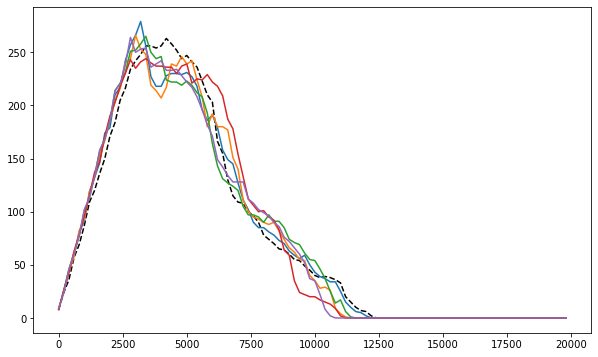

In [711]:
startdate = '2018-03-18'; enddate = '2018-03-19'
center = [-108.64188543338602,-72.7881345042331]

startdate = '2018-05-02'; enddate = '2018-05-03'
center = [-112.43216863651102,-72.22008468758618]

startdate = '2018-06-08'; enddate = '2018-06-09'
center = [-112.97049871463602,-72.15959892289469]

startdate = '2018-06-26'; enddate = '2018-06-27'
center = [-114.02518621463602,-72.33046021688021]

startdate = '2018-07-04'; enddate = '2018-07-05'
center = [-115.48636785526102,-72.70994073347087]

startdate = '2018-07-16'; enddate = '2018-07-17'
center = [-114.60746160526102,-72.6707148065568]

startdate = '2018-07-28'; enddate = '2018-07-29'
center = [-115.29960027713602,-72.78163147516548]

startdate = '2018-08-09'; enddate = '2018-08-10'
center = [-116.88163152713602,-72.69033854126403]

startdate = '2018-08-11'; enddate = '2018-08-12'
center = [-117.90885320682352,-72.55251880813104]

startdate = '2018-09-14'; enddate = '2018-09-15'
center = [-123.66568914432352,-71.91565947090466]

startdate = '2018-09-25'; enddate = '2018-09-26'
center = [-124.76981512088602,-72.17810177582666]

startdate = '2018-10-21'; enddate = '2018-10-22'
center = [-126.02225652713602,-72.25862442985495]

startdate = '2018-11-02'; enddate = '2018-11-03'
center = [-127.73932794578221,-72.5164287958811]

startdate = '2019-01-09'; enddate = '2019-01-10'
center = [-135.02005926151102,-73.51561972087731]

startdate = '2019-01-21'; enddate = '2019-01-22'
center = [-136.01981512088602,-73.45628528563523]

startdate = '2019-02-02'; enddate = '2019-02-03'
center = [-136.28903560641777,-73.37814251757015]

startdate = '2019-02-14'; enddate = '2019-02-15'
center = [-136.0098053553598,-73.34004195946177]

startdate = '2019-02-26'; enddate = '2019-02-27'
center = [-137.49795953362585,-73.39886267856943]

startdate = '2019-03-10'; enddate = '2019-03-11'
center = [-139.00284509494816,-73.887777250202]

buf_dist = 25000 # buffer distance to find from the center to find icebergs

map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# color codes to visualize the iceberg geometry by time
color_codes = ['red', 'chocolate', 'orange', 'yellow', 'olive', 'lime',
               'green', 'teal', 'cyan', 'blue', 'navy', 'purple']

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist);

# How many days are you testing?
day_range = range(0, 30) # for about year (2019-2018)

vectorscale = 40

features = []
fig = plt.subplots(figsize = (10, 6))
plt.plot(hist2['reference'][1][:-1], hist2['reference'][0], label = "reference", color = "k", linestyle = "--")

for day in day_range:
    
    month = dt.datetime.strptime(startdate, "%Y-%m-%d").month
    band = ["HH", "angle"]  # intersted band
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(ross_sea) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(100);
        
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH', 'angle'], ['HH', 'angle'])
        
        # Mapping original image ===================================
        vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0, 'region': ross_sea}
        mapid_seg[startdate] = img.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='S1_{0}'.format(startdate),
        ).add_to(map)
        
        # SNIC image segmentaion
        # https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 20, 5, 8, 256, seeds)\
        .select(["HH_mean", "angle_mean", "clusters"], ["HH", "angle", "clusters"])
        # ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)
        
        segments = snic.select("clusters").reduceToVectors(
            geometry = snic.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20
        )     
        
        segimageA = segments.reduceToImage(
            properties = ['label'],
            reducer = ee.Reducer.first()
        ).rename('id')

#         segimageB = img.addBands(segimageA)
        
#         ratio = segimageB.select("HH").divide(segimageB.select("angle"))
#         segimage = segimageB.addBands(ratio)
#         segimage = segimage.select(["HH", "id", "HH_1"], ["HH", "id", "ratio"])

#         segimage_mean = segimage.reduceConnectedComponents(
#             reducer = ee.Reducer.mean(),
#             labelBand = 'id',
#             maxSize = 512
#         ).select('ratio')      
        

#         icebergs = segimage_mean.select('ratio').gt(-0.2).selfMask()
        ratio = snic.select("HH").divide(snic.select("angle"))
        icebergs = ratio.gt(-0.2).selfMask()
        
        # Mapping segmented image ===================================
        vis_seg = {'bands': ["HH"], 'min': -0.5, 'max': -0.2, 'region': ross_sea}
        mapid_segimg = ratio.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_segimg['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='Segimage_{0}'.format(startdate),
        ).add_to(map)        
        
        # Map of segmentations =====================================
        vis_seg = {'color': 'red'}
        seg_tile = segments.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=seg_tile['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name="seg_" + startdate,
        ).add_to(map)
        
        # Convert iceberg raster to vector
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = area0 * 1.2
        area_min = area0 * 0.8
        areaAdded = vectors.map(addArea)
        # Add area and centroid information to the iceberg vectors
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        num = target.size().getInfo()
        features = target.getInfo()['features']
        
        print(startdate + " ============================================")
        threshold = 0.8
        
        for k in range(0, num): # if there is a valid iceberg
            
            area = features[k]['properties']['area']
            centroid = features[k]['properties']['centroid']['coordinates']
            polygon = ee.FeatureCollection(ee.Geometry.Polygon(features[k]['geometry']['coordinates'][0]))
            sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);
            covers = snic.select('HH').multiply(0).add(1)
            
            cumCost = covers.cumulativeCost(
                source = sources,
                maxDistance = 30000,
                geodeticDistance = True
            ).clip(polygon)

            result = cumCost.reduceRegion(ee.Reducer.toList(), polygon, scale = 200)
            cumdist = result.getInfo()['cumulative_cost']
            B = np.histogram(cumdist, int(max_pix/scale), [0, max_pix])  
            
            diff = abs(hist2['reference'][0] - B[0])
            similarity = 1-np.sum(diff)/np.sum(hist2['reference'][0])
            
            vis_target = {'color': color_codes[month-1]}
            mapid_target = polygon.getMapId(vis_target) 
            
            # Map of iceberg vectors
            folium.TileLayer(
                tiles=mapid_target['tile_fetcher'].url_format,
                attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
                overlay=True,
                name=startdate + "_" + str(k),
            ).add_to(map)           
            
            print("Feature {0} >>> area: {1} km^2, centroid: [{2}, {3}], similarity: {4}".format(
                k, round(area/1e6,2), round(centroid[0],3), round(centroid[1], 3), round(similarity, 3)
            ))                       
            
            if similarity >= threshold:
                
                ice_area[startdate] = area
                ice_centroid[startdate] = centroid
                hist2[startdate] = B   
                threshold = similarity
                
                plt.plot(B[1][:-1], B[0], label = startdate + "_" + str(k))
                
                def add_columns(feature):
                    return feature.set({"area": feature.geometry().area(10),
                                        "centroid": feature.geometry().centroid(10),
                                        "similarity": similarity,
                                        "refdate": '2017-05-01'});
                
                polygon2 = polygon.map(add_columns)
                
                task = ee.batch.Export.table.toDrive(
                    collection = polygon2,
                    folder = 'Iceberg_tracking_auto',
                    description = "Iceberg_{0}".format(startdate),
                    fileFormat = 'KML'
                )
                
                task.start()
                
                print("... exporting task for {0}".format(startdate))
                
                center = centroid
                buf_dist = 0
            
            
    if (buf_dist > 250000) or (startdate == "2019-03-23"): # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 25000 # add 25 km buffer for everyday searching process
    startdate = enddate
    enddate = (dt.datetime.strptime(enddate, "%Y-%m-%d") + dt.timedelta(days=1)).strftime("%Y-%m-%d")

# plt.legend()


## Phase 3 (2019/03/25-2019/12/31)

84246026.47867517


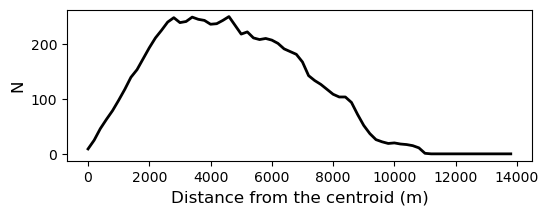

In [23]:
# Reference iceberg distribution
reference = ee.FeatureCollection('users/kooala317/iceberg_20190329')
centroid = reference.geometry().centroid(10).getInfo()['coordinates']

band = ["HH", "angle"]  # intersted band
    
# Load Sentinel-1 images (image collection)
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate('2019-03-29', '2019-03-30')\
.filterBounds(reference)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

img = S1A.select(band).mean().clip(reference) # clip image into ROI

scale = 200
max_pix = 14000

cover = img.select('HH').clip(reference).multiply(0).add(1)
cover = cover.addBands(ee.Image.pixelLonLat())
# coordinates = cover.reduceRegion(ee.Reducer.mean(), reference, scale = 200, maxPixels = 1e20).getInfo()

sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);

# kernel = ee.Kernel.euclidean(max_pix, "pixels");
# cumulativeCost = sources.distance(kernel, False).clip(reference)
# sources = sources.updateMask(cover);

# Compute the cumulative cost to traverse the land cover.
cumulativeCost = cover.select('HH').cumulativeCost(
    source = sources,
    maxDistance = 30000,
    geodeticDistance = True
).clip(reference)

if 'hist3' not in globals():
    hist3 = {}

fig = plt.subplots(figsize = (6, 2), dpi = 100)
result = cumulativeCost.reduceRegion(ee.Reducer.toList(), reference, scale = 200, maxPixels = 1e20);
A = result.getInfo()['cumulative_cost'] # 'cumulative_cost' 'constant'
hist3['reference'] = np.histogram(A, int(max_pix/scale), [0, max_pix])
area0 = reference.geometry().area(10).getInfo()
plt.plot(hist3['reference'][1][:-1], hist3['reference'][0], color = "k", linewidth = 2)
plt.xlabel("Distance from the centroid (m)", fontsize = 12)
plt.ylabel("N", fontsize = 12)

reference.getInfo()['features'][0]
reference.geometry().centroid(10).getInfo()
print(area0)

2019-04-10 ============================================
Feature 0 >>> area: 79.03 km^2, centroid: [-146.959, -74.768], similarity: 0.889
... exporting task for 2019-04-10
2019-04-11 ============================================
Feature 0 >>> area: 83.39 km^2, centroid: [-146.885, -74.645], similarity: 0.94
... exporting task for 2019-04-11
2019-04-12 ============================================
Feature 0 >>> area: 81.44 km^2, centroid: [-146.835, -74.586], similarity: 0.898
... exporting task for 2019-04-12
2019-04-15 ============================================
Feature 0 >>> area: 81.86 km^2, centroid: [-147.264, -74.549], similarity: 0.88
... exporting task for 2019-04-15


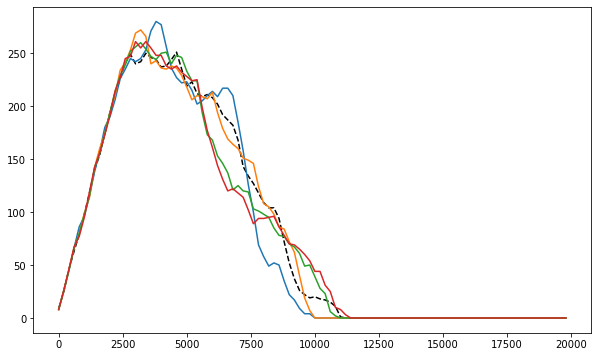

In [4]:
startdate = '2019-03-25'; enddate = '2019-03-26'
center = [-144.196, -74.194]

startdate = '2019-04-22'; enddate = '2019-04-23'
center = [-148.85184637088602,-74.54010574643914]

startdate = '2019-05-29'; enddate = '2019-05-30'
center = [-156.73324255086862,-76.24197557548395]

startdate = '2019-06-25'; enddate = '2019-06-26'
center = [-159.765867433003,-76.20434883050252]

startdate = '2019-12-03'; enddate = '2019-12-04'
center = [-172.02366479657988,-72.03584559268326]

startdate = '2019-12-05'; enddate = '2019-12-06'
center = [-171.99173228647626,-71.98634275272701]

startdate = '2019-12-27'; enddate = '2019-12-28'
center = [-172.27469793338602,-71.92759185065805]

# startdate = '2019-12-29'; enddate = '2019-12-30'
# center = [-172.46146551151102,-71.8182119631755]

startdate = '2019-04-10'; enddate = '2019-04-11'
center = [-146.95794261, -74.76693532]

buf_dist = 25000 # buffer distance to find from the center to find icebergs

map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# color codes to visualize the iceberg geometry by time
color_codes = ['red', 'chocolate', 'orange', 'yellow', 'olive', 'lime',
               'green', 'teal', 'cyan', 'blue', 'navy', 'purple']

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist);

# How many days are you testing?
day_range = range(0, 6) # for about year (2019-2018)

vectorscale = 40

features = []
fig = plt.subplots(figsize = (10, 6))
plt.plot(hist3['reference'][1][:-1], hist3['reference'][0], label = "reference", color = "k", linestyle = "--")

for day in day_range:
    
    month = dt.datetime.strptime(startdate, "%Y-%m-%d").month
    band = ["HH", "angle"]  # intersted band
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(ross_sea) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(80);
        
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH', 'angle'], ['HH', 'angle'])
        
        # Mapping original image ===================================
        vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0, 'region': ross_sea}
        mapid_seg[startdate] = img.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='S1_{0}'.format(startdate),
        ).add_to(map)
        
        # SNIC image segmentaion
        # https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 20, 5, 8, 256, seeds)\
        .select(["HH_mean", "angle_mean", "clusters"], ["HH", "angle", "clusters"])
        # ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)
        
        segments = snic.select("clusters").reduceToVectors(
            geometry = snic.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20
        )     
        
        segimageA = segments.reduceToImage(
            properties = ['label'],
            reducer = ee.Reducer.first()
        ).rename('id')      

        # icebergs = segimage_mean.select('ratio').gt(-0.2).selfMask()
        ratio = snic.select("HH").divide(snic.select("angle"))
        icebergs = ratio.gt(-0.2).selfMask()
        
        # Convert iceberg raster to vector
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = area0 * 1.3
        area_min = area0 * 0.7
        areaAdded = vectors.map(addArea)
        # Add area and centroid information to the iceberg vectors
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        num = target.size().getInfo()
        features = target.getInfo()['features']
        
        print(startdate + " ============================================")
        threshold = 0.70
        
        for k in range(0, num): # if there is a valid iceberg
            
            area = features[k]['properties']['area']
            centroid = features[k]['properties']['centroid']['coordinates']
            polygon = ee.FeatureCollection(ee.Geometry.Polygon(features[k]['geometry']['coordinates'][0]))
            sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);
            covers = snic.select('HH').multiply(0).add(1)
            
            cumCost = covers.cumulativeCost(
                source = sources,
                maxDistance = 30000,
                geodeticDistance = True
            ).clip(polygon)

            result = cumCost.reduceRegion(ee.Reducer.toList(), polygon, scale = 200)
            cumdist = result.getInfo()['cumulative_cost']
            B = np.histogram(cumdist, int(max_pix/scale), [0, max_pix])  
            
            diff = abs(hist3['reference'][0] - B[0])
            similarity = 1-np.sum(diff)/np.sum(hist3['reference'][0])         
            
            print("Feature {0} >>> area: {1} km^2, centroid: [{2}, {3}], similarity: {4}".format(
                k, round(area/1e6,2), round(centroid[0],3), round(centroid[1], 3), round(similarity, 3)
            ))                       
            
            if similarity >= threshold:
                
                ice_area[startdate] = area
                ice_centroid[startdate] = centroid
                hist3[startdate] = B   
                threshold = similarity
                
                plt.plot(B[1][:-1], B[0], label = startdate + "_" + str(k))
                
                def add_columns(feature):
                    return feature.set({"area": feature.geometry().area(10),
                                        "centroid": feature.geometry().centroid(10),
                                        "similarity": similarity,
                                        "refdate": '2017-05-01'});
                
                polygon2 = polygon.map(add_columns)
                
                task = ee.batch.Export.table.toDrive(
                    collection = polygon2,
                    folder = 'Iceberg_tracking_auto',
                    description = "Iceberg_{0}".format(startdate),
                    fileFormat = 'KML'
                )
                
                # task.start()
                
                print("... exporting task for {0}".format(startdate))
                
                center = centroid
                buf_dist = 0
            
            
    if (buf_dist > 250000) or (startdate == "2020-01-01"): # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 25000 # add 25 km buffer for everyday searching process
    startdate = enddate
    enddate = (dt.datetime.strptime(enddate, "%Y-%m-%d") + dt.timedelta(days=1)).strftime("%Y-%m-%d")

# plt.legend()


In [27]:
print(np.sum(B1[0])/np.sum(B0[0]))

0.997662944689691


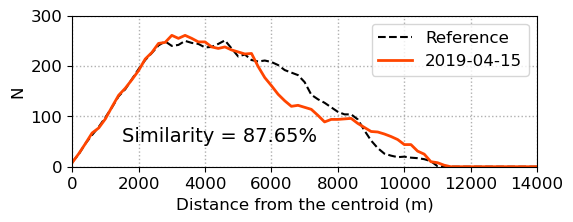

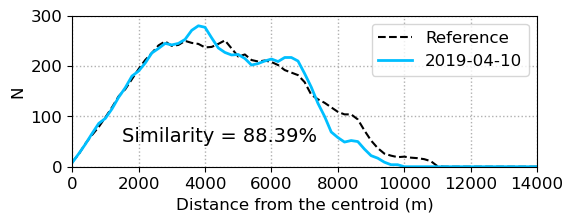

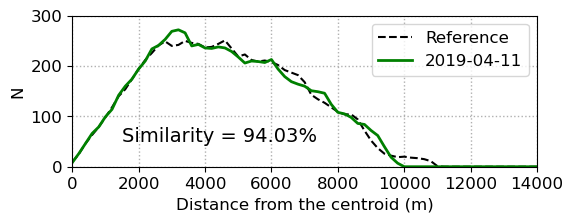

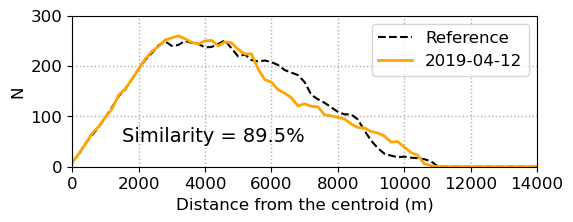

In [19]:
dates = ['2019-04-10', '2019-04-11', '2019-04-12', '2019-04-15']
colors = ["deepskyblue", "green", "orange", "orangered"]
for i in range(0, len(dates)):
    fig = plt.subplots(figsize = (6, 2), dpi = 100)
    B0 = hist3[dates[i-1]]
    B1 = hist3['reference'] #hist3[dates[i]]
    diff = abs(B1[0] - B0[0])
    similarity = 1-np.sum(diff)/np.sum(B0[0])  
    plt.plot(hist3['reference'][1][:-1], hist3['reference'][0], label = "Reference", color = "k", linestyle = "--")
    plt.plot(B0[1][:-1], B0[0], label = dates[i-1], linewidth = 2, color = colors[i-1])
#     plt.plot(B1[1][:-1], B1[0], label = dates[i], linewidth = 2, color = colors[i])
    plt.xlim(0, 14000)
    plt.ylim(0,300)
    plt.xlabel("Distance from the centroid (m)", fontsize = 12)
    plt.ylabel("N", fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.yticks(fontsize = 12)
    plt.text(1500, 50, "Similarity = {0}%".format(round(similarity * 100, 2)), fontsize = 14)
    plt.grid(linestyle = ":", linewidth = 1)
    plt.legend(fontsize = 12)
    plt.savefig("F:\Iceberg_tracking\graph\Similarity_{0}.png".format(dates[i-1]), bbox_inches = "tight")

In [9]:
hist3.keys()

dict_keys(['reference', '2019-04-10', '2019-04-11', '2019-04-12', '2019-04-15'])

## Phase4 (2020/01/01 - 2020/03/20)

76860906.20559217


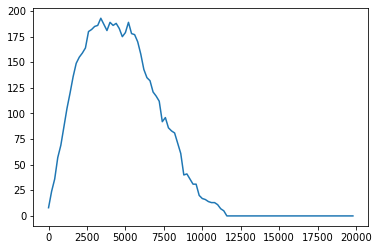

In [734]:
# Reference iceberg distribution
reference = ee.FeatureCollection('users/kooala317/iceberg_20200117')
centroid = reference.geometry().centroid(10).getInfo()['coordinates']

band = ["HH", "angle"]  # intersted band
    
# Load Sentinel-1 images (image collection)
S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
.filterDate('2020-01-17', '2020-01-18')\
.filterBounds(reference)\
.filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))

img = S1A.select(band).mean().clip(reference) # clip image into ROI

scale = 200
max_pix = 20000

cover = img.select('HH').clip(reference).multiply(0).add(1)
cover = cover.addBands(ee.Image.pixelLonLat())
# coordinates = cover.reduceRegion(ee.Reducer.mean(), reference, scale = 200, maxPixels = 1e20).getInfo()

sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);

# kernel = ee.Kernel.euclidean(max_pix, "pixels");
# cumulativeCost = sources.distance(kernel, False).clip(reference)
# sources = sources.updateMask(cover);

# Compute the cumulative cost to traverse the land cover.
cumulativeCost = cover.select('HH').cumulativeCost(
    source = sources,
    maxDistance = 30000,
    geodeticDistance = True
).clip(reference)

if 'hist4' not in globals():
    hist4 = {}

result = cumulativeCost.reduceRegion(ee.Reducer.toList(), reference, scale = 200, maxPixels = 1e20);
A = result.getInfo()['cumulative_cost'] # 'cumulative_cost' 'constant'
hist4['reference'] = np.histogram(A, int(max_pix/scale), [0, max_pix])
area0 = reference.geometry().area(10).getInfo()
plt.plot(hist4['reference'][1][:-1], hist4['reference'][0])

reference.getInfo()['features'][0]
reference.geometry().centroid(10).getInfo()
print(area0)

In [728]:
area0

76860906.20559217

2020-03-13 ============================================
Feature 0 >>> area: 68.61 km^2, centroid: [-178.777, -69.98], similarity: 0.799
... exporting task for 2020-03-13
2020-03-14 ============================================
Feature 0 >>> area: 68.54 km^2, centroid: [-178.864, -70.006], similarity: 0.806
... exporting task for 2020-03-14
2020-03-16 ============================================
Feature 0 >>> area: 66.46 km^2, centroid: [-178.719, -70.022], similarity: 0.783
... exporting task for 2020-03-16
2020-03-17 ============================================
2020-03-18 ============================================
Feature 0 >>> area: 71.45 km^2, centroid: [-178.681, -69.922], similarity: 0.839
... exporting task for 2020-03-18
2020-03-19 ============================================
Feature 0 >>> area: 64.05 km^2, centroid: [-178.821, -69.868], similarity: 0.753
... exporting task for 2020-03-19
2020-03-20 ============================================
Feature 0 >>> area: 62.21 km^2, ce

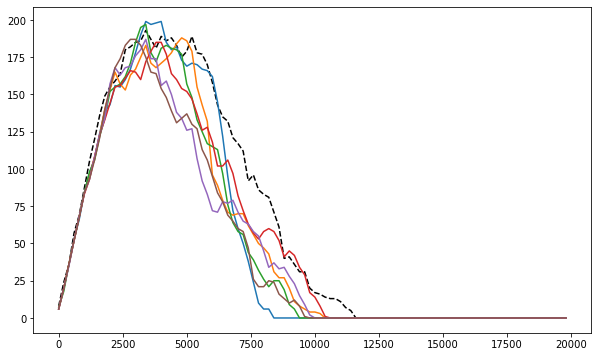

In [747]:
# startdate = '2019-12-31'; enddate = '2020-01-01'
# center = [-172.73063055057352,-71.76757955308366]

startdate = '2019-12-27'; enddate = '2019-12-28'
center = [-172.27469793338602,-71.92759185065805]

startdate = '2020-01-05'; enddate = '2020-01-06'
center = [-173.14948431033915,-71.81349774032267]

startdate = '2020-01-17'; enddate = '2020-01-18'
center = [-173.5202728845579,-71.79377091890227]

startdate = '2020-03-12'; enddate = '2020-03-13'
center = [-178.5959564783079,-69.9633528367943]

startdate = '2020-03-13'; enddate = '2020-03-14'
center = [-178.7827240564329,-69.9633528367943]

buf_dist = 25000 # buffer distance to find from the center to find icebergs

map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

# color codes to visualize the iceberg geometry by time
color_codes = ['red', 'chocolate', 'orange', 'yellow', 'olive', 'lime',
               'green', 'teal', 'cyan', 'blue', 'navy', 'purple']

# First buffer area in Ross Sea
ross_sea = ee.Geometry.Point(center).buffer(buf_dist);

# How many days are you testing?
day_range = range(0, 1) # for about year (2019-2018)

vectorscale = 40

features = []
fig = plt.subplots(figsize = (10, 6))
plt.plot(hist4['reference'][1][:-1], hist4['reference'][0], label = "reference", color = "k", linestyle = "--")

for day in day_range:
    
    month = dt.datetime.strptime(startdate, "%Y-%m-%d").month
    band = ["HH", "angle"]  # intersted band
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)\
    .filter(ee.Filter.listContains('transmitterReceiverPolarisation', "HH"))
    
    if S1A.size().getInfo() > 0:
        imageA = S1A.select(band).mean().clip(ross_sea) # clip image into ROI

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(100);
        
        # Gaussian kernel to softening the image (remove some salt and pepper noise)
        kernel = ee.Kernel.gaussian(3)
        img1 = imageA.convolve(kernel)
        img = img1.select(['HH', 'angle'], ['HH', 'angle'])
        
        # Mapping original image ===================================
        vis_seg = {'bands': ["HH"], 'min': -30, 'max': 0, 'region': ross_sea}
        mapid_seg[startdate] = img.getMapId(vis_seg)
        
        folium.TileLayer(
          tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
          attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
          overlay=True,
          name='S1_{0}'.format(startdate),
        ).add_to(map)
        
        # SNIC image segmentaion
        # https://developers.google.com/earth-engine/apidocs/ee-algorithms-image-segmentation-snic
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 20, 5, 8, 256, seeds)\
        .select(["HH_mean", "angle_mean", "clusters"], ["HH", "angle", "clusters"])
        # ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)
        
        segments = snic.select("clusters").reduceToVectors(
            geometry = snic.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20
        )     
        
        segimageA = segments.reduceToImage(
            properties = ['label'],
            reducer = ee.Reducer.first()
        ).rename('id')      

        # icebergs = segimage_mean.select('ratio').gt(-0.2).selfMask()
        ratio = snic.select("HH").divide(snic.select("angle"))
        icebergs = ratio.gt(-0.2).clip(ross_sea).selfMask()
        
        # Convert iceberg raster to vector
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = vectorscale,
            geometryType = 'polygon',            
            maxPixels = 1e20)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = area0 * 1.2
        area_min = area0 * 0.8
        areaAdded = vectors.map(addArea)
        # Add area and centroid information to the iceberg vectors
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        num = target.size().getInfo()
        features = target.getInfo()['features']
        
        print(startdate + " ============================================")
        threshold = 0.70
        
        for k in range(0, num): # if there is a valid iceberg
            
            area = features[k]['properties']['area']
            centroid = features[k]['properties']['centroid']['coordinates']
            polygon = ee.FeatureCollection(ee.Geometry.Polygon(features[k]['geometry']['coordinates'][0]))
            sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);
            covers = snic.select('HH').multiply(0).add(1)
            
            cumCost = covers.cumulativeCost(
                source = sources,
                maxDistance = 30000,
                geodeticDistance = True
            ).clip(polygon)

            result = cumCost.reduceRegion(ee.Reducer.toList(), polygon, scale = 200)
            cumdist = result.getInfo()['cumulative_cost']
            B = np.histogram(cumdist, int(max_pix/scale), [0, max_pix])  
            
            diff = abs(hist4['reference'][0] - B[0])
            similarity = 1-np.sum(diff)/np.sum(hist4['reference'][0])         
            
            print("Feature {0} >>> area: {1} km^2, centroid: [{2}, {3}], similarity: {4}".format(
                k, round(area/1e6,2), round(centroid[0],3), round(centroid[1], 3), round(similarity, 3)
            ))                       
            
            if similarity >= threshold:
                
                ice_area[startdate] = area
                ice_centroid[startdate] = centroid
                hist4[startdate] = B   
                threshold = similarity
                
                plt.plot(B[1][:-1], B[0], label = startdate + "_" + str(k))
                
                def add_columns(feature):
                    return feature.set({"area": feature.geometry().area(10),
                                        "centroid": feature.geometry().centroid(10),
                                        "similarity": similarity,
                                        "refdate": '2017-05-01'});
                
                polygon2 = polygon.map(add_columns)
                
                task = ee.batch.Export.table.toDrive(
                    collection = polygon2,
                    folder = 'Iceberg_tracking_auto',
                    description = "Iceberg_{0}".format(startdate),
                    fileFormat = 'KML'
                )
                
                task.start()
                
                print("... exporting task for {0}".format(startdate))
                
                center = centroid
                buf_dist = 0
            
            
    if (buf_dist > 250000) or (startdate == "2020-03-22"): # If the buffer distance become so large, break the loop
        print("!!! STOP !!! buffer {0} km ( {1} )".format(buf_dist, startdate))
        break
    
    buf_dist += 25000 # add 25 km buffer for everyday searching process
    startdate = enddate
    enddate = (dt.datetime.strptime(enddate, "%Y-%m-%d") + dt.timedelta(days=1)).strftime("%Y-%m-%d")

# plt.legend()

In [ ]:
clip_test = img.clip(merged)

clip_polygon = merged.geometry().dissolve().filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))

map = folium.Map(location=[center[1], center[0]], height=550,width=700)

vis_seg = {'bands': ['HH'], 'min': 0, 'max': 1, 'region': ross_sea}
# lat_test = clip_test.getMapId(vis_seg)
lat_test = clip_polygon.getMapId({'color': 'red'})

folium.TileLayer(
  tiles=lat_test['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='iceberg_{0}'.format(i),
).add_to(map)
map

In [ ]:
clip_polygon.getInfo()

In [ ]:
map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)
first = True
for i in range(0, len(features)):
    A = ee.Geometry.Polygon(features[i]['geometry']['coordinates'][0])
    value_mean = cluster.reduceRegion(reducer=ee.Reducer.mean(), geometry=A,
                                      scale = 100, maxPixels=1e9).getInfo()["ratio"]
    if value_mean >= -0.2:
        if first:
            merged = ee.FeatureCollection(A)
            first = False
        else:
            merged = merged.merge(ee.FeatureCollection(A))
        print(i, value_mean)

# Map of segmentations
vis_seg = {'color': 'red'}
seg_tile = merged.getMapId(vis_seg)

folium.TileLayer(
    tiles=seg_tile['tile_fetcher'].url_format,
    attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    overlay=True,
    name="seg_" + startdate,
).add_to(map)


print(value_mean)

map.add_child(folium.LayerControl())
map

In [ ]:
map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)
# Map of segmentations
vis_seg = {'color': 'red'}
seg_tile = merged.getMapId(vis_seg)

folium.TileLayer(
  tiles=seg_tile['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name="seg_" + startdate,
).add_to(map)


print(value_mean)

map.add_child(folium.LayerControl())
map

In [ ]:
features = target.getInfo()['features']
features[0]['geometry']['coordinates'][0]

In [ ]:
sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);
cover = img_sizes.select('HH').gt(-50).multiply(0).add(1)

# sources = sources.updateMask(cover);

# Compute the cumulative cost to traverse the land cover.
cumulativeCost = cover.cumulativeCost(
    source = sources,
    maxDistance = 50000,
    geodeticDistance = True
).clip(target)

map = folium.Map(location=[center[1], center[0]], height=550,width=700)

vis_seg = {'bands': ['cumulative_cost'], 'min': 0, 'max': 15000, 'region': ross_sea}
lat_test = cumulativeCost.getMapId(vis_seg)

folium.TileLayer(
  tiles=lat_test['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='S1_{0}'.format(startdate),
).add_to(map)

scale = 500
max_pix = 15000
result = cumulativeCost.reduceRegion(ee.Reducer.toList(), target, scale);
A = result.getInfo()['cumulative_cost']
B = np.histogram(A, int(max_pix/scale), [0, max_pix])
plt.plot(B[1][:-1], B[0])

map.add_child(folium.LayerControl())
map

In [ ]:
sources = ee.Image().toByte().paint(ee.Geometry.Point(centroid), 1);
cover = img_sizes.select('HH').gt(-50).multiply(0).add(1)

# sources = sources.updateMask(cover);

# Compute the cumulative cost to traverse the land cover.
cumulativeCost = cover.cumulativeCost(
    source = sources,
    maxDistance = 50000,
    geodeticDistance = True
).clip(target)

map = folium.Map(location=[center[1], center[0]], height=550,width=700)

vis_seg = {'bands': ['cumulative_cost'], 'min': 0, 'max': 15000, 'region': ross_sea}
lat_test = cumulativeCost.getMapId(vis_seg)

folium.TileLayer(
  tiles=lat_test['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='S1_{0}'.format(startdate),
).add_to(map)

scale = 500
max_pix = 15000
result = cumulativeCost.reduceRegion(ee.Reducer.toList(), target, scale);
A = result.getInfo()['cumulative_cost']
B = np.histogram(A, int(max_pix/scale), [0, max_pix])
plt.plot(B[1][:-1], B[0])

map.add_child(folium.LayerControl())
map



In [ ]:
scale = 500
max_pix = 14000
result = cumulativeCost.reduceRegion(ee.Reducer.toList(), target, scale);
A = result.getInfo()['cumulative_cost']
B = np.histogram(A, int(max_pix/scale), [0, max_pix])
plt.plot(B[1][:-1], B[0])

In [ ]:
A = result.getInfo()['cumulative_cost']
B = np.histogram(A, 100, [0, 15000])
plt.plot(B[1][:-1], B[0])

In [ ]:
target.getInfo()

In [ ]:
x = []
y = []
for polygon in vectors.getInfo()['features']:
    coord = polygon['geometry']['coordinates'][0]
    
    coord = np.array(polygon['geometry']['coordinates'][0])
    plt.hist(np.sum((coord - np.median(coord,0))**2, 1)**0.5, histtype = 'step', density = False)
    
    x.append(polygon['properties']['count'])
    y.append(len(polygon['geometry']['coordinates'][0]))
    

In [ ]:
coord = np.array(polygon['geometry']['coordinates'][0])
plt.hist(np.sum((coord - np.mean(coord,0))**2, 1), histtype = 'step')

In [ ]:
np.sum((coord - np.median(coord,0))**2, 1)**0.5

### Comparison with NIC iceberg archieve

In [48]:
import glob
from shapely.geometry import Point
import numpy as np
import geopandas
import shapefile

# Pandas Dataframe (daily) to ESRI Shapefile (.shp) ===============================
def convertshp(df, outfile):

    df = df.reset_index(drop=True)

    if len(df) > 0:
        df['geometry'] = df.apply(lambda x: Point((float(x.Longitude), float(x.Latitude))), axis=1)
        collist = list(df.columns)
        collist.remove('time')
        df2 = df[collist]

        df2 = geopandas.GeoDataFrame(df2, geometry='geometry')

        # proj WGS84
        df2.crs = "+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"

        df2.to_file(outfile, driver='ESRI Shapefile')

    print('... converted to ' + outfile)

csvfiles = sorted(glob.glob("F:/Iceberg_tracking/NIC icebergs/*.csv"))

first = True
dftime = []
for i in range(0, len(csvfiles)):
    df0 = pd.read_csv(csvfiles[i])
    df0 = df0[df0["Iceberg"] == "B43"].reset_index()
    
    if len(df0) > 0:
        df0['time'] = dt.datetime.strptime(df0["Last Update"][0], "%m/%d/%Y")
        if first:
            df = df0
            first = False
        else:
            df = df.append(df0).reset_index(drop = True)
            
convertshp(df, "F:/Iceberg_tracking/NIC icebergs/NIC_iceberg_B43.shp")

... converted to F:/Iceberg_tracking/NIC icebergs/NIC_iceberg_B43.shp


In [45]:
len(df)

154

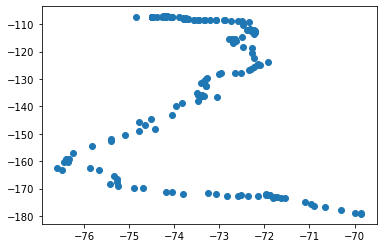

In [39]:
plt.scatter(df['Latitude'], df['Longitude'])

In [28]:
df0["Last Update"]

19    8/30/2019
Name: Last Update, dtype: object

### Find overlapped ICESat-2 data

In [27]:
import shapefile

def read_shapefile(shp_path):   

    #read file, parse out the records and shapes
    sf = shapefile.Reader(shp_path)
    fields = [x[0] for x in sf.fields][1:]
    records = sf.records()
    # shps = [s.points for s in sf.shapes()]
    shps = [s.points for s in sf.shapes()]
    X = []
    Y = []
    
    for p in shps:
        X.append(p[0][0])
        Y.append(p[0][1])

    #write into a dataframe
    df = pd.DataFrame(columns=fields, data=records)
    df = df.assign(coords=shps)
    df = df.assign(x=X)
    df = df.assign(y=Y)

    return df.reset_index(drop = True)

shpfile = r"F:\Iceberg_tracking\icebergs_shp_auto\iceberg_2all_filtered.shp"
icebergs = read_shapefile(shpfile)

In [28]:
## Read ATL10 times in Ross Sea
import datetime as dt
import glob
import time

path = r'F:\2020_Antarctic\ATL10_Ross'
# file directory you want to read from

dF_time = []

# Load Sentinel-2 images (image collection)
sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR")

# Ross Sea boundary
ross_sea = ee.Geometry.Rectangle([160, -78, -150, -70])

# for L in list1:
#     print(L)

IS2_track = ee.FeatureCollection("users/kooala317/Antarctica_IS2_laser7")
iceberg_all = ee.FeatureCollection("users/kooala317/Iceberg_2all_filtered")

bounding_box = [160, -78, -150, -70] # Ross Sea
# bounding_box = [ll_lon, ll_lat, ur_lon, ur_lat]

# Directly from local files (ATL10) -----------------
dirpath = path + '\*003_03.h5' # version 2 data
filelist = sorted(glob.glob(dirpath))

# From the file list (csv file) of ADAPT (ATL03) ---------------
files = pd.read_csv(r"F:\ATL03\ATL03\ATL03_RossSea.csv")
filelist = files.name

selectfiles = []
prog = 0
start = time.time()

first = True

finding_dis = 50000
iceberg = iceberg_all.filter(ee.Filter.eq("date", "2018-10-21"))
ROI = iceberg.geometry().buffer(finding_dis);
iceberg_date = icebergs.date.tolist()

for k in range(0, len(filelist)):
    f = filelist[k]
    t = f.split('ATL03_')[1][:14]
    t0 = dt.datetime.strptime(t, "%Y%m%d%H%M%S")
    dF_time.append(t0)
    
    t1 = t0.strftime("%Y-%m-%d")
    t2 = (t0+dt.timedelta(days=1)).strftime("%Y-%m-%d")  
    
    if t1 in iceberg_date:
        iceberg = iceberg_all.filter(ee.Filter.eq("date", t1))
        ROI = iceberg.geometry().buffer(finding_dis);

    # Find Sentinel-2 image that is overlapped with the ICESat-2 track
    # track_id = str(int(f.split('ATL10-02_')[1][15:19])) # ATL10
    track_id = str(int(f.split('ATL03_')[1][15:19])) # ATL10
    # Track ID of ICESat-2 (1-1387)
    track = IS2_track.filter(ee.Filter.eq("Name", track_id)).filterBounds(ROI)
    # Filtering the Shpfile of the track ID

    num = track.size().getInfo()
    
    if num > 0:
        print(t1, track_id)
    
    prog += 1
    now = time.time()
    
    if prog % 200 == 0:    
        print("... {0} / {1} ({2} %, {3} sec)".format(prog, len(filelist),
                                                      round(prog/len(filelist)*100, 2),
                                                      round(now-start, 3)))
        
# df.to_csv(r"F:\Iceberg_tracking\IS2\ATL03_RossSea_selected.csv")

2018-10-20 333
2018-10-20 333
... 200 / 13034 (1.53 %, 1001.423 sec)
2018-10-24 394
2018-10-24 394
... 400 / 13034 (3.07 %, 1960.242 sec)
2018-10-28 455
2018-10-28 463
2018-10-28 463
2018-10-28 455
2018-10-31 503
2018-11-01 516
2018-11-01 524
2018-11-01 524
2018-11-01 516
... 600 / 13034 (4.6 %, 2925.396 sec)
2018-11-05 585
2018-11-05 577
2018-11-05 585
2018-11-05 577
2018-11-09 638
2018-11-09 646
2018-11-09 646
2018-11-09 638
... 800 / 13034 (6.14 %, 3828.009 sec)
2018-11-13 707
2018-11-13 707
2018-11-17 768
2018-11-17 768
... 1000 / 13034 (7.67 %, 4663.206 sec)
2018-11-21 829
2018-11-21 829
2018-11-25 890
... 1200 / 13034 (9.21 %, 5838.147 sec)
2018-11-25 890
2018-11-29 951
2018-11-29 951
2018-11-29 945
2018-11-29 945
... 1400 / 13034 (10.74 %, 7016.19 sec)
2018-12-03 1012
2018-12-03 1012
2018-12-08 1080
2018-12-08 1080
... 1600 / 13034 (12.28 %, 8332.11 sec)
2018-12-12 1136
2018-12-12 1141
2018-12-12 1141
2018-12-12 1136
... 1800 / 13034 (13.81 %, 9595.836 sec)
2018-12-16 1202
2018-

In [ ]:
value_mean

In [ ]:
IS2_track = ee.FeatureCollection("F:\Iceberg_tracking\ATH_20190711_040000_20200713_110000.KML")
# Red points
vis_ATL = {'color': 'red'}
mapid_ATL = IS2_track.getMapId(vis_ATL)

folium.TileLayer(
  tiles=mapid_ATL['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='ATL03',
).add_to(map)

map.add_child(folium.LayerControl())
map

In [ ]:
# map.add_child(folium.LayerControl())
map

In [ ]:
imageA = S1A.mean().select('HH').clip(ross_sea) # clip image into ROI

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.cbook as cbook

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()
testdates = list(ice_area.keys())[::-1]
dates = []
arealist = []
for day in testdates:
    dates.append(dt.datetime.strptime(day, "%Y-%m-%d"))
    arealist.append(ice_area[day] / 1000000) 
    
df = pd.DataFrame({"date": dates, "area": arealist})
fig, ax = plt.subplots(figsize = (12, 4))
ax.tick_params(labelsize  = 14)
ax.set_xlabel("date", fontsize = 14)
ax.set_ylabel("area (km^2)", fontsize = 14)
ax.scatter(df.date, df.area)
ax.grid(linestyle = ':', linewidth = 0.5)
# ax.xaxis.set_major_locator(months)

In [ ]:
dates

In [ ]:
import datetime as dt

# 2019-12-12 to 2019-10-10
path = r'F:\2020_Antarctic\ATL10_Ross'
# file directory you want to read from

# initial condition
startdate = '2019-12-12'
enddate = '2019-12-13'
center = [-172.3, -71.9]
buf_dist = 25000

color_codes = ['magenta', 'maroon', 'red', 'orange', 'olive', 'green',
              'teal', 'blue', 'navy', 'purple']
color_idx = 0

ross_sea = ee.Geometry.Point([-172.3, -71.9]).buffer(buf_dist);

map = folium.Map(location=[center[1], center[0]], zoom_start=7, height=550,width=700)

day_range = range(0, 180)

for day in day_range:
    
    # Ross Sea region
    # ross_sea = ee.Geometry.Rectangle([-172.23, -73.76, -169.32, -72.80]) # rectangle
    ross_sea = ee.Geometry.Point(center).buffer(buf_dist)

    # Load Sentinel-1 images (image collection)
    S1A = ee.ImageCollection("COPERNICUS/S1_GRD")\
    .filterDate(startdate, enddate)\
    .filterBounds(ross_sea)
    # .filter(ee.Filter.eq('transmitterReceiverPolarisation', ["HH","HV"]))\
    
    if S1A.size().getInfo() > 0:
        bands = ['HH']
        imageA = S1A.mean().select(bands).clip(ross_sea)

        seeds = ee.Algorithms.Image.Segmentation.seedGrid(50);
        img = imageA
        
        snic = ee.Algorithms.Image.Segmentation.SNIC(img, 25, 5, 8, 256).select(["HH_mean", "clusters"], ["HH", "clusters"])
        # snic = ee.Algorithms.Image.Segmentation.SNIC(img, 32, 5, 8, 256, seeds).select(["HH_mean", "clusters"], ["HH", "clusters"])
        # ee.Algorithms.Image.Segmentation.SNIC(image, size, compactness, connectivity, neighborhoodSize, seeds)

        cluster = snic.select("HH")       
        
        value_mean = cluster.reduceRegion(reducer=ee.Reducer.mean(), geometry=cluster.geometry(),
                                          scale = 100, maxPixels=1e9).getInfo()['HH']
#         value_min = cluster.reduceRegion(reducer=ee.Reducer.min(), geometry=cluster.geometry(),
#                                          scale = 100, maxPixels=1e9).getInfo()['HH']
#         value_max = cluster.reduceRegion(reducer=ee.Reducer.max(), geometry=cluster.geometry(),
#                                          scale = 100, maxPixels=1e9).getInfo()['HH']
        value_std = cluster.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=cluster.geometry(), 
                                         scale = 100, maxPixels=1e9).getInfo()['HH']
        
        normal = cluster.subtract(value_mean).divide(value_std)
        
        icebergs = normal.gt(2.5).selfMask()

        objectId = icebergs.connectedComponents(ee.Kernel.plus(1), 256)
        # print(objectId)
        vectors = icebergs.reduceToVectors(
            geometry = icebergs.geometry(),
            scale = 80,
            geometryType = 'polygon',
            labelProperty = 'target',
            maxPixels = 1e12)

        def addArea(feature):
            return feature.set({"area": feature.geometry().area(10), "centroid": feature.geometry().centroid(10)});

        area_max = 95000000
        area_min = 75000000
        areaAdded = vectors.map(addArea)
        target = areaAdded.filter(ee.Filter.gt('area', area_min)).filter(ee.Filter.lt('area', area_max))
        
        if target.size().getInfo() > 0:
            area = target.getInfo()['features'][0]['properties']['area']
            centroid = target.getInfo()['features'][0]['properties']['centroid']['coordinates']

            ice_area[startdate] = area
            ice_centroid[startdate] = centroid

            # Mapping
            vis_seg = {'bands': bands, 'min': -3, 'max': 3, 'region': ross_sea}
            mapid_seg[startdate] = normal.getMapId(vis_seg)

            vis_target = {'color': color_codes[color_idx%len(color_codes)]}
            mapid_target[startdate] = target.getMapId(vis_target)            

            # Map of Sentinel1 segmentation image
            folium.TileLayer(
              tiles=mapid_seg[startdate]['tile_fetcher'].url_format,
              attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
              overlay=True,
              name='S1_{0}'.format(startdate),
            ).add_to(map)

            # Map of iceberg
            folium.TileLayer(
              tiles=mapid_target[startdate]['tile_fetcher'].url_format,
              attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
              overlay=True,
              name=startdate,
            ).add_to(map)
            
            print("{0} area: {1} km^2, centroid: {2}".format(startdate, round(area/1e6,3), centroid))            
            
            center = centroid
            buf_dist = 0
            color_idx += 1
    
    buf_dist += 25000
    enddate = startdate
    startdate = (dt.datetime.strptime(startdate, "%Y-%m-%d") - dt.timedelta(days=1)).strftime("%Y-%m-%d")
    
    if buf_dist > 200000:
        break

map.add_child(folium.LayerControl())
map

In [ ]:
target = areaAdded.filter(ee.Filter.gt('area', 10000000))
print(target.getInfo()['features'][0]['properties']['area'])
print(target.getInfo()['features'][0]['properties']['centroid']['coordinates'])

In [ ]:
cluster = snic.select("HH")       

value_mean = cluster.reduceRegion(reducer=ee.Reducer.mean(), geometry=cluster_mean.geometry(),
                                  scale = 100, maxPixels=1e9).getInfo()['HH']
value_min = cluster.reduceRegion(reducer=ee.Reducer.min(), geometry=cluster_mean.geometry(),
                                 scale = 100, maxPixels=1e9).getInfo()['HH']
value_max = cluster.reduceRegion(reducer=ee.Reducer.max(), geometry=cluster_mean.geometry(),
                                 scale = 100, maxPixels=1e9).getInfo()['HH']
value_std = cluster.reduceRegion(reducer=ee.Reducer.stdDev(), geometry=cluster_mean.geometry(), 
                                 scale = 100, maxPixels=1e9).getInfo()['HH']


normal = cluster.subtract(value_mean).divide(value_std)

In [ ]:
# Load Sentinel-2 images (image collection)
sentinel2 = ee.ImageCollection("COPERNICUS/S2_SR")

# Load ATL03 shpfile that you have uploaded as an asset
ATL03 = ee.FeatureCollection("users/kooala317/ATL03_20191113082415_07240512")

# Ross Sea boundary
ross_sea = ee.Geometry.Rectangle([-175, -78, -140, -76])

# Filter date and region of interest - Date: 11/13/2019, Region: Ross Sea
S2 = sentinel2.filterDate('2019-11-13', '2019-11-14').filterBounds(ross_sea)

# Visualize parameters of Sentinel-2
# Bands: RGB (B4, B3, B2); Maximum value: 10000; Minimum value: 0
vis_S2 = {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 10000, 'region': ross_sea}
mapid_S2 = S2.getMapId(vis_S2)

# Visualize parameters of ATL03 shpfile
# Red points
vis_ATL = {'color': 'red', 'pointRadius': 20}
mapid_ATL = ATL03.getMapId(vis_ATL)

# Mapping
map = folium.Map(location=[-77.3, -167], zoom_start=7, height=550,width=900)

# Map of Sentinel2
folium.TileLayer(
  tiles=mapid_S2['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='Sentinel-2',
).add_to(map)

# Map of ATL03
folium.TileLayer(
  tiles=mapid_ATL['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='ATL03',
).add_to(map)

map.add_child(folium.LayerControl())
map


On the above map, the red points are the ATL03 data, and the background image is the Sentinel-2 image. As you can see, the overlapped Sentinel-2 image can be used as a "ground truth" to classify sea ice and lead (open water) for the ATL03 data. Please compare the elevation profile you made before and the overlapped images. Can you find any characteristics of the leads?

Now let's check the properties of the Sentinel-2 image.

In [ ]:
info = S2.getInfo()
print(info['features'][0]['id'])

What's the time of the Sentinel-2 image? How much different are the Sentinel-2 time and ATL03 time?

### (4) Classification of Sentinel-2 image in GEE
Now you will classify the Sentinel-2 image into snow/ice, thin ice, and open water area by executing below code. A basic classification algorithm of Google Earth Engine called CART will be used. Please take a look at this link if you want to get more information about the CART algorithm and another classficiation algorithm. (https://developers.google.com/earth-engine/classification)

#### Step 1) Set the training points
For supervised classification, it is necessary to set the training points. I have selected 20 training points for each 3 class (snow/ice, thin ice, and open water), so you can use the geocoordinates (latitude, longitude) of those points.

In [ ]:
# Train points for open water area
openwater = ee.Geometry.MultiPoint(
    [[-168.27786460219284,-76.90528245210405],
     [-168.11903189712507,-76.90470174783454],
     [-168.1353251147998,-76.94187020284937],
     [-170.60494281092326,-77.64750804703299],
     [-169.90181781092323,-77.79528440274146],
     [-170.11055804529823,-77.71372738002661],
     [-170.48409320154832,-77.66805593392988],
     [-170.08201992147622,-77.3440301222582],
     [-170.03052150839028,-77.35004637944313],
     [-169.16544085824842,-77.09068063556724],
     [-169.16870242441053,-77.09374832828082],
     [-169.177972138766,-77.0759285240584],
     [-169.42992547085282,-77.08310624718435],
     [-166.29823709457503,-76.90575188796782],
     [-166.23506570785628,-76.91383865554515],
     [-166.7387515506607,-76.76906759663308],
     [-167.05551424571206,-76.75547614198565],
     [-166.81056088117361,-76.59882706931224],
     [-166.6945177903533,-76.61965880317706],
     [-167.02808942916067,-76.57839045231368],
     [-167.3596718988582,-76.41392638427682]]
)

# Train points for snow/ice area
snowice = ee.Geometry.MultiPoint(
    [[-168.03671869849268,-76.75427895788526],
     [-167.75078078787908,-76.79855536889755],
     [-167.41295119803533,-76.8057668293947],
     [-165.97751343054006,-76.83749101371046],
     [-167.29700960804826,-77.06204986504967],
     [-167.70437807332803,-76.94107020449589],
     [-167.21685976278116,-76.93455232030357],
     [-168.31654928021487,-76.8375941021728],
     [-168.41383580970262,-77.10377924428722],
     [-166.8833736164495,-77.26945938845569],
     [-168.49561726879324,-77.29545915242738],
     [-167.357008012552,-77.45566572832413],
     [-168.65064814927075,-77.45805168041487],
     [-166.91480830552075,-77.48426769913877],
     [-170.61737238679154,-77.24120972944536],
     [-169.82635676179154,-77.12667114471384],
     [-169.84832941804154,-77.29175149322165],
     [-167.57810591645637,-76.48575798268779],
     [-167.47098921723762,-76.52165419079782],
     [-168.17960738130012,-76.56639287266482],
     [-166.97385786958137,-76.41690950796679]]
)

# Train points for dark ice area
darkice = ee.Geometry.MultiPoint(
    [[-166.8338006228853,-77.1189881188955],
     [-166.66076595491654,-77.15231532670694],
     [-166.96151668733842,-77.15567390981192],
     [-166.87911922640092,-77.1449845116625],
     [-167.57478365080817,-77.14055752400908],
     [-167.87004121916755,-77.13260847643495],
     [-168.48859677347525,-76.93018410912723],
     [-168.80170712503775,-76.91433644646227],
     [-168.32792172464713,-76.96987561847533],
     [-168.95949021269928,-76.9409676797993],
     [-170.00568352842345,-77.20654334872535],
     [-166.8057806299438,-77.39829152319173],
     [-167.40728209478755,-77.39649371233646],
     [-166.60250504498185,-76.75550283178868],
     [-167.82301862767804,-76.6924152947673],
     [-166.7248431265068,-76.59649832908742],
     [-165.7510907902914,-76.72153402569772],
     [-165.74697091724454,-76.69722463541235],
     [-165.55523649923293,-76.44455443574773],
     [-165.85324064962356,-76.36514448796221],
     [-165.28744475118606,-76.40781128313075]]
)

# Collect all these train points and make one feature collection to train
polygons = ee.FeatureCollection([
  ee.Feature(openwater, {'class': 0}),
  ee.Feature(darkice, {'class': 1}),
  ee.Feature(snowice, {'class': 2})
])

print("Complete setting training points")

#### Step 2) Train model
For the training points, the CART model will be trained.

In [ ]:
# Only use RGB bands will be used. (B4, B3, B2)
bands = ['B4', 'B3', 'B2']
image = S2.mean().select(bands);

# Sampling the image by training points
training = image.sampleRegions(collection = polygons, properties = ['class'], scale = 10)

# Train CART classification model
trained = ee.Classifier.smileCart().train(training, 'class', bands)
# Classify the image with the same bands used for training.
classified = image.classify(trained);

print("Classification is completed!")

#### Step 3) Visualize Classification Result

In [ ]:
# Visualization parameters for classification result
# class 0: open water, black
# class 1: dark ice (thin ice), blue
# class 2: snow/ice, white
vclass = classified.getMapId({'palette': ['black', 'orange', 'white'], 'min': 0, 'max': 2})

map = folium.Map(location=[-77.3, -166.5], zoom_start=7, height=550,width=900)

# Map of Sentinel-2 true color image
folium.TileLayer(
  tiles=mapid_S2['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='Sentinel-2',
).add_to(map)

# Map of Classification result
folium.TileLayer(
  tiles=vclass['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='classification',
).add_to(map)

# Map of ATL03
folium.TileLayer(
  tiles=mapid_ATL['tile_fetcher'].url_format,
  attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
  overlay=True,
  name='ATL03',
).add_to(map)

map.add_child(folium.LayerControl())
map